# Unconstrained optimization: the Truncated Newton Method
-  **Giacomo Bacchetta**, <bacchetta.1840949@studenti.uniroma1.it>, LinkedIn: <https://www.linkedin.com/in/giacomobacchetta/>
-  **Edoardo Cesaroni**, <cesaroni.1841742@studenti.uniroma1.it>, LinkedIn: <https://www.linkedin.com/in/edoardocesaroni/>
-  **Fabio Ciccarelli**, <ciccarelli.1835348@studenti.uniroma1.it>, LinkedIn: <https://www.linkedin.com/in/fabio-ciccarelli-601399198/>

## Packages' import

Import of built-in python functions to compute gradient.
- $\bf{Autograd.numpy}$, equivalent to the better known numpy package;
- $\bf{Autograd}$, used to calculate the gradient (*grad*) of the functions taken into account;
- $\bf{matplotlib}$, which allows us to represent graphically the data.

In [1]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt

## Armijo Condition

The $\bf{Armijo}$ condition is a line search method used to determine the step $\alpha$ to move along a given search direction $d$. It can be described as follows:
1. Set $ \alpha > 0,\delta \in (0,1), \gamma \in (0,\frac{1}{2})$
2. Until the condition $f(x_k + \alpha \cdot d) > f(x_k) + \alpha \cdot \gamma \cdot (\nabla(f(x_k)) \times  d)$ is satisfied, then $\alpha = \alpha \cdot \delta$

In [2]:
def armijo(f, x_k, d):
    alpha = 1
    delta = 0.5
    gamma = 1e-3

    while True:
        if f(x_k + alpha*d) > f(x_k) + alpha * gamma * (grad(f)(x_k) @ d):
            alpha = delta * alpha
        else:
            return alpha

## Other useful functions

The $\bf{mxv}$ function has the goal to return the result of the product between a matrix and a vector. In particular, we applied the incremental ratio formula to carry out this product.

The $\bf{gradfi}$ function helps us to define the descent direction. To do this we have to minimize the quadratic function $\phi$ by setting its gradient to 0.

In [3]:
def mxv(v, f, x):
    eta = 1e-6
    x_succ = x + eta*v
    return (grad(f)(x_succ) - grad(f)(x))/eta


def gradfi(d,f,x):
    return mxv(d,f,x) + grad(f)(x)

# Truncated Newton Method

### Theory overview

The Truncated Newton method can be described as follows:
- given a certain starting point $x_0 \in R^n$, then at each iteration $k$ we have:

$\newline$

$$
x_{k+1}=x_k+\alpha_k d_k ;
$$

$\newline$

where
- $\alpha_k$ is computed applying Amrijo criterion with $\alpha_0=1$ (see above);
- we get the direction $d_k$ as described below:

**S0**: given $\varepsilon_1>0, \ \varepsilon_2>0$, we set $p_0=0, s_0=-\nabla \phi_k\left(p_0\right)=-\nabla f\left(x_k\right)$ and $i=0$.

$\newline$

If $s_0^T \nabla^2 f\left(x_k\right) s_0<\varepsilon_1\left\|s_0\right\|^2$ then $d_k=-\nabla f\left(x_k\right)$. Stop;

$\newline$


**S1**: we set

$\newline$

$$
p_{i+1}=p_i+\alpha_i s_i ; \quad \alpha_i=-\frac{\nabla \phi_k\left(p_i\right)^T s_i}{s_i^T \nabla^2 f\left(x_k\right) s_i}
$$

$\newline$

**S2**: if
$$
\left\|\nabla \phi_k\left(p_{i+1}\right)\right\| \leq \frac{1}{k+1} \varepsilon_2\left\|\nabla f\left(x_k\right)\right\|
$$

$\newline$
then $d_k=p_{i+1}$. Stop; Otherwise $i=i+1$;

$\newline$

**S3**:
$$
s_i=-\nabla \phi_k\left(p_i\right)+\beta_i s_{i-1}, \quad \quad \beta_i=\frac{\nabla \phi_k\left(p_i\right)^T \nabla^2 f\left(x_k\right) s_{i-1}}{s_{i-1}^T \nabla^2 f\left(x_k\right) s_{i-1}}
$$

$\newline$

**S4**: if

$\newline$

$$
s_i^T \nabla^2 f\left(x_k\right) s_i<\varepsilon_1 \|\left. s_i\right\|^2
$$

$\newline$

then $d_k=p_i$. Stop; Otherwise go back to $\mathrm{S} 1$;

## Software implementation

In [4]:
def dt(f, x, k):

    epsilon_1 = 0.5
    epsilon_2 = 0.5
    p = 0
    
    s = -grad(f)(x)
    
    if (s @ mxv(s, f, x)) < (epsilon_1 * (np.linalg.norm(s))**2):
        d = -(grad(f)(x))
        return d
    
    while True:
        
        if (s @ mxv(s, f, x)) <= 1e-9:              
            return -grad(f)(x)
        
        alfa = -((gradfi(p, f, x) @ s) / (s @ mxv(s, f, x)))
        p = p + alfa * s

        if np.linalg.norm(gradfi(p, f, x)) <= (1/(k+1))*epsilon_2*(np.linalg.norm(grad(f)(x))):
            d = p
            return d
        
        else:
            beta = (gradfi(p, f, x) @ mxv(s, f, x)) / (s @ mxv(s, f, x))
            s = -(gradfi(p, f, x)) + beta * s

            if (s @ mxv(s, f, x)) < (epsilon_1 * (np.linalg.norm(s))**2):
                d = p
                return d

In [5]:
def nt(f, x, eps = 1e-5):  
    
    norm_grad = [np.linalg.norm(grad(f)(x))]
        
    k = 0
    
    if np.linalg.norm(grad(f)(x)) < eps:
        return x
    
    while True:
        
        d = dt(f, x, k)
        a = armijo(f, x, d)
        x = x + a * d
        
        if norm_grad[-1] > 0.1:
            norm_grad.append(np.linalg.norm(grad(f)(x)))
        
        
        if np.linalg.norm(grad(f)(x)) <= eps:
            print('Successful convergence to a local optimum \n x\u002A:', x.round(3), '\n f(x\u002A):', round(f(x), 4))
            
            plt.plot(range(len(norm_grad)), norm_grad)
            plt.title('Speed of convergence', fontweight = 'bold')
            plt.xlabel('Iterations')
            plt.ylabel('Gradient norm')
            
            return x
        
        k = k + 1

## Reliability tests

From now on, we define unconstrained problems to test the NT method. The solutions can be compared with those on the attached pdf file.

### Wood Function

$$
\begin{aligned}
&f(x)=100\left(x_1^2-x_2\right)^2+\left(x_1-1\right)^2+\left(x_3-1\right)^2+90\left(x_3^2-x_4\right)^2 \\
&\quad+10.1\left[\left(x_2-1\right)^2+\left(x_4-1\right)^2\right]+19.8\left(x_2-1\right)\left(x_4-1\right), \\
& \\
&x_0=[-3,-1,-3,-1]^T, \\
&x^*=[0,0,0,0]^T, \\
&f\left(x^*\right)=0 .
\end{aligned}
$$


Successful convergence to a local optimum 
 x*: [1. 1. 1. 1.] 
 f(x*): 0.0


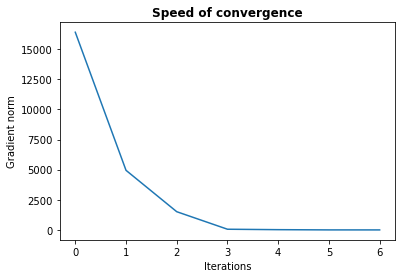

In [6]:
def x0_wood():
    x = np.array([-3. ,-1. ,-3. ,-1.])
    return x

def wood(x):
    return 100*(x[0]**2-x[1])**2 + (x[0]-1.)**2 + (x[2]-1.)**2 + 90.*(x[2]**2-x[3])**2 + 10.1*((x[1]-1.)**2 + (x[3]-1.)**2.) + 19.8*(x[1]-1.)*(x[3]-1.)

nt(wood, x0_wood());

### Scaled Rosenbrock Function

$$
\begin{aligned}
&f(x)=c\left(x_2-x_1^2\right)^2+\left(1-x_1\right)^2 \newline
&x_0=[-1.2,1]^T \newline 
&x^*=[1,1]^T \newline 
&f\left(x^*\right)=0
\end{aligned}
$$

Successful convergence to a local optimum 
 x*: [1. 1.] 
 f(x*): 0.0


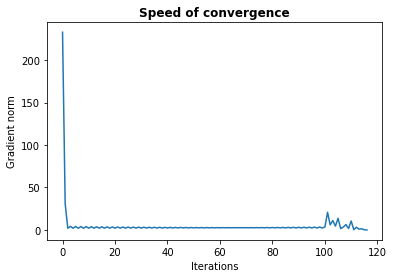

In [7]:
def rosenbrock(x):
    return sum((100*(x[i+1]-x[i]**2)**2 + (1-x[i])**2) for i in range(len(x)-1))

def x0_rosenbrock(n):
    x_0 = np.zeros(n)
    for i in range(0, n-1, 2):
        x_0[i] = -1.2
        x_0[i+1] = 1
    return x_0

nt(rosenbrock, x0_rosenbrock(2));

### Cube Function

$$
\begin{aligned}
&f(x)=c\left(x_2-x_1^3\right)^2+\left(1-x_1\right)^2 \\
&x_0=[-1.2,1]^T \\
&x^*=[1,1]^T \\
&f\left(x^*\right)=0
\end{aligned}
$$


Successful convergence to a local optimum 
 x*: [1. 1.] 
 f(x*): 0.0


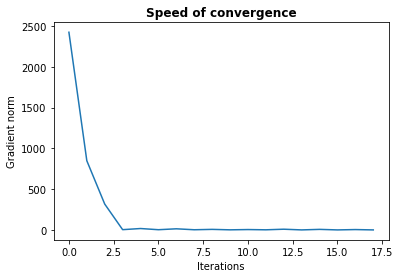

In [8]:
def x0_cube():
    return np.array([-1.2, 1])

def cube(x):
    c = 10**2
    return c*(x[1] - x[0]**3) **2 + (1 - x[0])**2

nt(cube, x0_cube());

### Powell Function

$$
\begin{aligned}
f(x)=& \sum_{i=1}^{n / 4}\left[\left(x_{4 i-3}+10 x_{4 i-2}\right)^2+5\left(x_{4 i-1}-x_{4 i}\right)^2\right.\\
&\left.+\left(x_{4 i-2}-2 x_{4 i-1}\right)^4+10\left(x_{4 i-3}-x_{4 i}\right)^4\right] \\
& \\
&x_0= {[3,-1,0,1, \ldots, 3,-1,0,1]^T } \\
&x^*=[0, \ldots, 0]^T \\
&f\left(x^*\right)=0
\end{aligned}
$$



Successful convergence to a local optimum 
 x*: [ 0.006  0.011 -0.001  0.006] 
 f(x*): 0.0


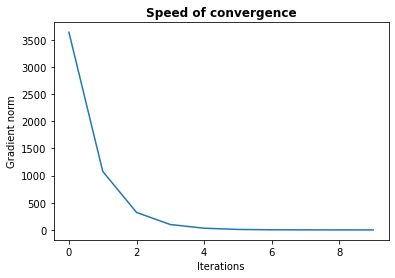

In [9]:
def powell(x):
    n = len(x)
    return sum((x[4*i-3]+10*x[4*i-2])**2+5*(x[4*i-1]-x[4*i])**2 + (x[4*i-2]-2*x[4*i-1])**4 + 10*(x[4*i-3]-x[4*i])**4 for i in range(int(n/4)))

def x0_powell(n):
    x = np.zeros(n)
    for i in range(0, n, 4):
        x[i] = 3
        x[i+1] = -1
        x[i+2] = 0
        x[i+3] = 1
    return x

nt(powell, x0_powell(4));

### Dixon Function

$$
\begin{aligned}
&f(x)=\left(x_1-1\right)^2+\sum_{i=2}^n i\left(2 x_i^2-x_{i-1}\right)^2 \\
&x_0=[1, \ldots, 1]^T \\
& f\left(x^*\right)=0
\end{aligned}
$$


Successful convergence to a local optimum 
 x*: [1.    0.707 0.595 0.545] 
 f(x*): 0.0


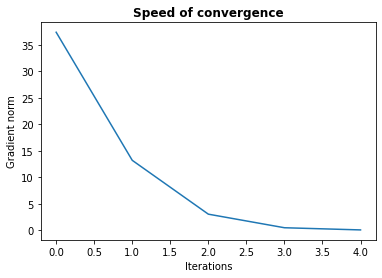

In [10]:
def dixon(x):
    return (x[0]-1)**2 + sum(i*(2*(x[i-1]**2)-x[i-1-1])**2 for i in range(2,len(x)+1))

def x0_dixon(n):
    return np.ones(n)

nt(dixon, x0_dixon(4));

### Box Function

$$
\begin{aligned}
&f(x)=\sum_{i=1}^{10}\left[e^{-t_i x_1}-e^{-t_i x_2}-x_3\left(e^{-t_i}-e^{-10 t_i}\right)\right]^2, \\
&t_i=0.1 i, \\
&x_0=[0,10,20]^T, \\
&f\left(x^*\right)=0, \quad \text { at }[1,10,1]^T, \quad[10,1,-1]^T, \\
&\text { and wherever } x_1=x_2 \quad \text { and } \quad x_3=0 .
\end{aligned}
$$

Successful convergence to a local optimum 
 x*: [ 0.999 10.01   1.001] 
 f(x*): 0.0


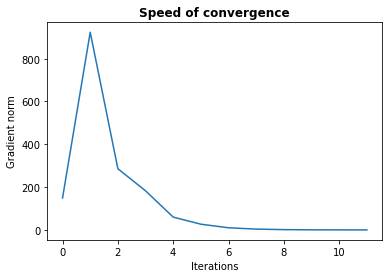

In [11]:
def box(x):
    return sum((np.exp(-0.1*i*x[0])-np.exp(-0.1*i*x[1])-x[2]*(np.exp(-0.1*i)-np.exp(-i)))**2 for i in range(1, 11))

def x0_box():
    return np.array([0. ,10. ,20.])

nt(box, x0_box());

### Oren Function

$$
\begin{aligned}
&f(x)=\left[\sum_{i=1}^n i x_i^2\right]^2, \\
&x_0=[1, \ldots, 1]^T, \\
&x^*=[0, \ldots, 0]^T, \\
&f\left(x^*\right)=0 .
\end{aligned}
$$


Successful convergence to a local optimum 
 x*: [1.    0.014 0.    0.   ] 
 f(x*): 0.0


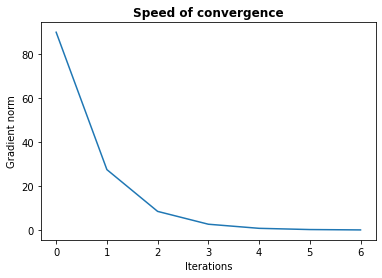

In [12]:
def oren(x):
    f = 0
    for i in range (0,len(x)):
        f += (i*(x[i]**2))
    return f**2

def x0_oren(n):
    x_1 = np.zeros(n)
    for i in range (0,n):
        x_1[i] = 1
    return x_1 

nt(oren, x0_oren(4));

### Separated Rosenbrock Function

$$
\begin{aligned}
&f(x)=\sum_{i=1}^{n / 2}\left[100\left(x_{2 i}-x_{2 i-1}^2\right)^2+\left(1-x_{2 i-1}\right)^2\right] \\
&x_0=[-1.2,1, \ldots,-1.2,1]^T, \\
&x^*=[1, \ldots, 1]^T \\
&f\left(x^*\right)=0
\end{aligned}
$$


Successful convergence to a local optimum 
 x*: [1. 1. 1. 1.] 
 f(x*): 0.0


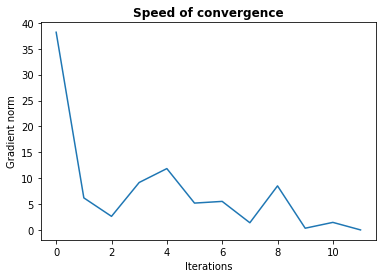

In [13]:
def separatedRose(x):
    f = 0
    c = 10.**1
    for j in range(0,len(x),2):
        f = f + (1. - x[j])**2 + c*(x[j+1] - x[j]**2)**2
    return f

def x0_separatedRose(n):
    x = np.zeros(n)
    for i in range(0,n,2):
        x[i] = -1.2
        x[i+1] = 1
    return x

nt(separatedRose, x0_separatedRose(4));